In [1]:
import bm3d
import os, sys, glob
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio


orig_stdout = sys.stdout
orig_stderr = sys.stderr
f = open('output_bm3d_patch.txt', 'w')
#sys.stderr = f
#sys.stdout = f


In [35]:
import h5py
import numpy as np

total_denoised_img = {}
sigma_psd = 40
for set_file in sorted(glob.glob("test_Samsung_SNU_patches_SET*.hdf5")):
    print(f"==== {set_file} ====")
    set_num = set_file.split('_')[-1].split('.')[0]
    #print(set_num)
    set_prev_psnr = []
    set_prev_ssim = []
    set_psnr = []
    set_ssim = []
    with h5py.File(set_file,'r') as f:
        
        for idx, img in enumerate(zip(f['noisy_images'],f['clean_images'])):
            noisy_img, clean_img = img 
            noisy_img, clean_img = (noisy_img*255).astype('uint8'), (clean_img*255).astype('uint8') 
            # [0,255]:PSNR 15.7177, SSIM : 0.0883
            # [0,1] : PSNR 15.7177, SSIM : 0.1799
            #print(noisy.shape, clean.shape)
            
            ssim = structural_similarity(clean_img,noisy_img)
            psnr = peak_signal_noise_ratio(clean_img,noisy_img)
            set_prev_psnr.append(psnr); set_prev_ssim.append(ssim); 
            print(f"before  denoising PSNR {psnr:.4f}, SSIM : {ssim:.4f}")
            
            denoised_img = bm3d.bm3d(noisy_img,sigma_psd)
            
            total_denoised_img[f"{set_num}_idx{idx}"] = denoised_img
            denoised_img_uint8 = denoised_img.astype('uint8')
            # not uint8 PSNR 20.0293, SSIM : 0.2434
            # in uint8 PSNR 19.9339, SSIM : 0.2432  
            """
            ssim = structural_similarity(clean_img,denoised_img)
            psnr = peak_signal_noise_ratio(clean_img,denoised_img)
            """
            ssim = structural_similarity(clean_img,denoised_img_uint8)
            psnr = peak_signal_noise_ratio(clean_img,denoised_img_uint8)
            set_psnr.append(psnr); set_ssim.append(ssim); 
            print(f"after   denoising PSNR {psnr:.4f}, SSIM : {ssim:.4f}",flush=True)
            sys.exit(-1)
    print(f"before  denoising {set_num} avg PSNR :{np.mean(set_prev_psnr)} , avg SSIM : {np.mean(set_prev_ssim)}")
    print(f"after   denoising {set_num} avg PSNR :{np.mean(set_psnr)} , avg SSIM : {np.mean(set_ssim)}")
    np.save(f'bm_denoised_patch{set_num}.npy',total_denoised_img)

==== test_Samsung_SNU_patches_SET1.hdf5 ====
before  denoising PSNR 15.7177, SSIM : 0.1799
after   denoising PSNR 4.1605, SSIM : 0.0006


/tmp/ipykernel_56084/1732603652.py:39: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_img,denoised_img_uint8)


SystemExit: -1

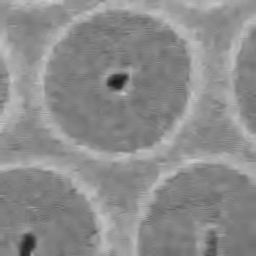

In [34]:
# input : scale [0,255], uint8
PIL.Image.fromarray(denoised_img_uint8)

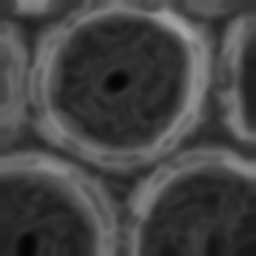

In [38]:
# input scale [0,1], fp32
factor = 6
PIL.Image.fromarray((denoised_img*255*factor).astype('uint8'))

In [ ]:

sys.stdout = orig_stdout
sys.stderr = orig_stderr
f.close()